In this tutorial, we would like to implement VALMOD algorithm proposed in paper [VALMOD](https://arxiv.org/pdf/2008.13447.pdf), and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [14]:
%matplotlib inline

import stumpy
from stumpy import core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

**Notation:** $T_{i,m} = T[i:i+m]$, a subsequence of `T` that starts at index `i` and has length `m` 

### Motif discovery

For a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$, Motif set $S^{m}_{r}$ is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

We would like to find set $S^{*} = \bigcup\limits_{m=min\_m}^{max\_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty because both these two subsequences start from the same index.

### Discord discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: For the subsequence $T_{i,m}$, its $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequence and its ($n^{th}$ ?) best match. <br>

**NOTE**:<br>
Why should I care about $n^{th}$ discord (n>1)? We provide a simple example below:

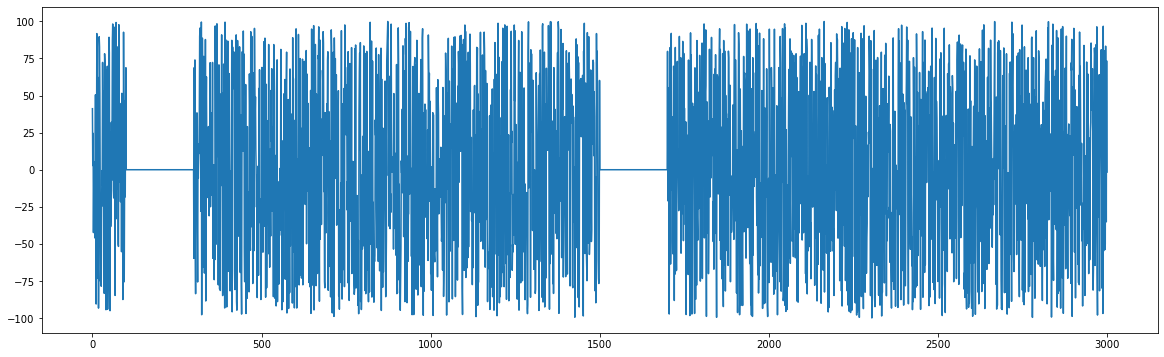

In [97]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0 for them. Therefore, we may need to investigate other neighbors rather than just 1NN. 

For further details, see Fig. 2 of the paper. Notice that `Top-1 2nd discord` subsequence has a close 1-NN; however, it is far from its 2nd closest neighbor.)

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`,`K`, and `N`, we want to find **top-k $n^{th}$ discord** for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2- Lower-Bound Distance Profile (for z-normalize case)

The idea goes as follows: "given the distance profile of $T_{j,m}$, how can we find a lower bound for distance profile of $T_{j,m+k}$", where $T_{j,m+k}$ represents a sequence that starts from the same index `j` with length `m+k`?

In other words, can we find **Lower Bound (LB)** for $d(T_{j,m+k}, T_{i,m+k})$ only by help of $T_{j,m}$, $T_{i,m}$, and $T_{j,m+k}$? (So, the last `k` elements of $T_{i,m+k}$ are unknown)

### Derving Equation (2)


$$
\begin{align}
    d^{(m+k)}_{j,i} ={}& 
        \sqrt{\sum\limits_{t=1}^{m+k}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}} 
    \\
    \geq{}&
        \sqrt{\sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}}
    \\
\end{align}
$$



$$
\begin{align}
    LB ={}& 
        \min \sqrt{\sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}}\right)
        }^{2}}} 
    \\
    ={}&
    \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \times \min \sqrt{\sum\limits_{t=1}^{m}{\left(\frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)^{2}}}
    \\
\end{align}
$$


Note that the variables are $\mu_{i,m+k}$ and $\sigma_{i,m+k}$. We subtitute $\mu_{i,m+k}$ with $\mu^{'}$, and $\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}$ with $\sigma^{'}$.


$$
\begin{align}
    f(\mu^{'}, \sigma^{'}) ={}& 
        \sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)
        }^{2}} 
    \\
\end{align}
$$



$$
\begin{align}
    X_{t} \triangleq{}& 
        {
        \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}
        } 
    \\
\end{align}
$$


To find critical point(s):


$$
\begin{align}
    \frac{\partial{f}}{\partial{\mu^{'}}} = 0 \quad \text{(1)}
    \\
    \frac{\partial{f}}{\partial{\sigma^{'}}} = 0 \quad \text{(2)}
    \\
\end{align}
$$



$$
\begin{align}
    \frac{\partial{f}}{\partial{\mu^{'}}} ={}& 
    \sum \limits_{t=1}^{m} {\frac{-2}{\sigma^{'}}X_{t}} \Rightarrow \text{with (1):}
    \sum \limits_{t=1}^{m} X_{t} = 0 \quad (3)
\end{align}
$$



$$
\begin{align}
    \frac{\partial{f}}{\partial{\sigma^{'}}} ={}& 
    \sum{\frac{-2}{\sigma^{'2}}\left(T[i+t-1] - \mu^{'}\right)X_{t}} \Rightarrow {\text{with (2) and (3)}}:
    \sum \limits_{t=1}^{m} T[i+t-1]X_{t} = 0 \quad (4)
\end{align}
$$


Exapanding (3):


$$
\begin{align}
    \sum \limits_{t=1}^{m} X_{t} = 0
    \\
    \sum \limits_{t=1}^{m} {\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}} = 0
    \\
    \frac{1}{\sigma^{'}}\left(\sum \limits_{t=1}^{m}T[i+t-1] - \sum \limits_{t=1}^{m} \mu^{'}\right) - 
    \frac{1}{\sigma_{j,m}}\left(\sum \limits_{t=1}^{m}T[j+t-1] - \sum \limits_{t=1}^{m} \mu_{j,m+k}\right) = 0
    \\
    \frac{1}{\sigma^{'}}\left(m\mu_{i,m} - m\mu^{'}\right) - 
    \frac{1}{\sigma_{j,m}}\left(m\mu_{j,m} - m\mu_{j,m+k}\right) = 0
    \\
    \sigma_{j,m}\left(\mu_{i,m} - \mu^{'}\right) - 
    \sigma^{'}\left(\mu_{j,m} - \mu_{j,m+k}\right) = 0
    \\
    \sigma_{j,m} \mu^{'} + 
    \left(\mu_{j,m} - \mu_{j,m+k}\right)\sigma^{'} - \sigma_{j,m}\mu_{i,m} = 0 \quad (5)
\end{align} 
$$


Expanding (4):


$$
\begin{align}
    \sum \limits_{t=1}^{m} T[i+t-1] \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right) = 0
    \\
\end{align}
$$



$$
\begin{align}
    \frac{1}{\sigma^{'}}\left(\sum \limits_{t=1}^{m} T[i+t-1]T[i+t-1] - \sum \limits_{t=1}^{m} T[i+t-1] \mu^{'}\right) - \frac{1}{\sigma_{j,m}}\left({\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] - \sum \limits_{t=1}^{m}T[i+t-1]\mu_{j,m+k}}\right) = 0
    \\
\end{align}
$$



$$
\begin{align}
    r \triangleq \frac{\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] - m\mu_{i,m}\mu_{j,m} }{m\sigma_{i,m}\sigma_{j,m}} \quad (6)
    \\
\end{align}
$$



$$
\begin{align}
    \frac{1}{\sigma^{'}}\left(m(\mu_{i,m}^{2} + \sigma_{i,m}^{2}) - m \mu_{i,m} \mu^{'}\right) - \frac{1}{\sigma_{j,m}}\left({m(r\sigma_{i,m}\sigma_{j,m} + \mu_{i,m}\mu_{j,m}) - m\mu_{i,m}\mu_{j,m+k}}\right) = 0
    \\
\end{align}
$$



$$
\begin{align}
    \mu_{i,m}\sigma_{j,m}\mu^{'} + (r\sigma_{i,m}\sigma_{j,m} + \mu_{i,m}\mu_{j,m} - \mu_{i,m}\mu_{j,m+k})\sigma^{'} - \sigma_{j,m}(\mu_{i,m}^{2} + \sigma_{i,m}^{2}) = 0 \quad (7)
    \\
\end{align}
$$


Solving (5) and (7) gives:


$$
\begin{align}
    \mu^{'} = \mu_{i,m} - \frac{\sigma^{'}}{\sigma_{j,m}}(\mu_{j,m}-\mu_{j,m+k}) \quad (8)
\end{align}
$$

$$
\begin{align}
    \sigma^{'} = \frac{\sigma_{i,m}}{r} \quad (9)
\end{align}
$$

We can try to simply $f_{min}(\mu^{'}, \sigma^{'})$ first with help of (3) and (4) before plugging in the values $\mu^{'}$ (8) and $\sigma^{'}$ (9).


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}& 
        \sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)
        }^{2}} 
    \\
    ={}&
    \sum\limits_{t=1}^{m}{{
        \left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)
        }X_{t}}
    \\
    ={}&
      {
        \frac{\sum\limits_{t=1}^{m}T[i+t-1]X_{t} - \sum\limits_{t=1}^{m}\mu^{'}X_{t}}{\sigma^{'}} - \frac{\sum\limits_{t=1}^{m}T[j+t-1]X_{t} - \sum\limits_{t=1}^{m}\mu_{j,m+k}X_{t}}{\sigma_{j,m}}
     } 
    \\ 
    ={}&
      {
         - \frac{1}{\sigma_{j,m}} \sum\limits_{t=1}^{m}T[j+t-1]X_{t}
     } 
    \\
    ={}&
      {
         - \frac{1}{\sigma_{j,m}} \sum\limits_{t=1}^{m}{T[j+t-1]\left(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}\right)}
     } 
    \\
\end{align}
$$


with (6), (8), and (9), we can get:


$$
\begin{align}
    f_{min}(\mu^{'},\sigma^{'}) ={}& 
        m (1 - r^{2}) 
    \\
\end{align}
$$


**Therefore, the lower-bound `LB` for distance profile of `T[j:j+m+k]` is as follows:**


$$
\begin{align}
    LB ={}& 
        \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \sqrt{m (1 - r^{2})} \quad \text{if} \, r > 0
    \\
\end{align}
$$

$$
\begin{align}
    r ={}& 
    \frac{\sum \limits_{t=1}^{m}T[i+t-1]T[j+t-1] - m\mu_{i,m}\mu_{j,m} }{m\sigma_{i,m}\sigma_{j,m}}
    \\
\end{align}
$$


**Note:** <br>
* Note that eq(9) is valid only for $r > 0$. Therefore, we can use the formula above to calculate $LB$ only if $r > 0$. 
* The pearson correlation, `r`, can be also obtained with help of $ED_{z-norm}$ between subsequences `T[i:i+m]` and `T[j:j+m]`.

**Pending...** <br>
* The proof is not complete. We need to take the second derivatives and make sure the discovered values give local minimum and not maximum or saddle point. Also, we need to analyze the behavior of function `f` to verify that this local minimum is actually the global minimum for this function.

* For $r \leq 0$, the authors claimed that: $LB = \frac{\sigma_{j,m}}{\sigma_{j,m+k}} \sqrt{m}$.